The SK model:
### Sherrington–Kirkpatrick (SK) Spin Glass Model

The Hamiltonian of the Sherrington–Kirkpatrick model is

$$
\mathcal{H}_N(\boldsymbol{\sigma})
= - \sum_{1 \le i < j \le N} J_{ij}\,\sigma_i \sigma_j
\;-\;
\sum_{i=1}^{N} h_i\,\sigma_i ,
$$

where the terms are defined as follows:

- $\sigma_i \in \{+1,-1\}$ are **Ising spins**, representing binary degrees of freedom.
- $J_{ij}$ are **quenched random couplings** between spins $i$ and $j$, drawn independently from a Gaussian distribution
  $$
  J_{ij} \sim \mathcal{N}\!\left(0,\frac{J^2}{N}\right),
  $$
  often with $J^2 = 1$.
- The scaling $1/N$ ensures a **well-defined thermodynamic limit**, so that the total energy is extensive (of order $N$).
- $h_i$ is an **external field** acting on spin $i$ (often taken as $h_i = h$ or $h_i = 0$).
- The first term encodes **frustrated interactions** due to random signs of $J_{ij}$.
- The second term biases spins toward alignment with the external field.

The SK model is a **mean-field spin glass**, meaning every spin interacts with every other spin with random strength.


### The Transformer architecture and its components

### High-level Thesis Vision

This thesis investigates a two-way bridge between spin glass theory and transformer models:

Forward direction (Goal I):
Use transformers as learned statistical models to approximate and simulate equilibrium properties of spin glasses.

Reverse direction (Goal II):
Use spin-glass concepts (overlaps, Gibbs measures, replica symmetry breaking, free energy) to develop new tools for interpretability and intervention in transformers.

The unifying idea is that both systems are large, high-dimensional, disordered systems whose macroscopic behavior is better described by distributions over states than by individual parameters.

Goal 1 : 
sub goal 1 : Do MCMC sampling to generate the data which will train the transformer. sub goal 2: Compare QKD dot product ( unnormalized attention) with h_eff ( effective field ) sub goal 3: compare attention with probabilities. sub goal 4: once there is sufficient correlation for sg 3 or sg 4 for multiple runs , you have good reason to believe the model has internalized the spin glass physics, and then you can find a way to compute thermodynamic properties using it, and then validate using some numerical ground truth. 


Note: Attention is simply normalized dot product , probability of sigma_i given config is normalized h_eff times some constant, so they have to be analgous 

Goal 2: Can Spin Glass ideas such as ultrametricity, Replica Symmetry Breaking , TAP equations, cavity method, improve interpretability and intervenability in Transformers. 

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys; sys.executable

'c:\\Users\\MridulKC\\cuda_env\\Scripts\\python.exe'

In [6]:

%pip install --upgrade pip
%pip install matplotlib
%pip install scipy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Goal 1:

In [8]:
# ============================================================
# Spin Glass ↔ Transformer Raw-QK Alignment Experiment
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ============================================================
# DEVICE
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


<>:90: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
<>:90: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
C:\Users\MridulKC\AppData\Local\Temp\ipykernel_7064\787949819.py:90: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  logits (binary classification) for predicting σ_i \in {−1, +1}.



===== N = 10 =====
  beta = 5
Spearman = -0.808912 | 
  beta = 10
Spearman = -0.210796 | 
  beta = 15
Spearman = 0.658343 | 
  beta = 19
Spearman = -1.000000 | 

===== N = 30 =====
  beta = 5
Spearman = -0.656148 | 
  beta = 10
Spearman = -1.000000 | 
  beta = 15


C:\Users\MridulKC\AppData\Local\Temp\ipykernel_7064\787949819.py:260: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, p_value = spearmanr(h_vals, qk_sum_vals)


Spearman = nan | 
  beta = 19
Spearman = 1.000000 | 

===== N = 50 =====
  beta = 5
Spearman = 0.795279 | 
  beta = 10
Spearman = 1.000000 | 
  beta = 15
Spearman = 0.746032 | 
  beta = 19
Spearman = 0.172932 | 

===== N = 70 =====
  beta = 5
Spearman = 0.187966 | 
  beta = 10
Spearman = 0.458388 | 
  beta = 15
Spearman = nan | 
  beta = 19
Spearman = -0.898023 | 

===== N = 90 =====
  beta = 5
Spearman = -0.257852 | 
  beta = 10
Spearman = 0.760094 | 
  beta = 15
Spearman = nan | 
  beta = 19
Spearman = -0.767162 | 
min(h) = 0.8610257506370544 max(h) = 0.9601121544837952 std(h) = 0.036663277340049746
min(h) = 0.8610257506370544 max(h) = 0.9601121544837952 std(h) = 0.036663277340049746
min(h) = 0.8610257506370544 max(h) = 0.9601121544837952 std(h) = 0.036663277340049746
min(h) = 0.8610257506370544 max(h) = 0.9601121544837952 std(h) = 0.036663277340049746
min(h) = 0.8610257506370544 max(h) = 0.9601121544837952 std(h) = 0.036663277340049746


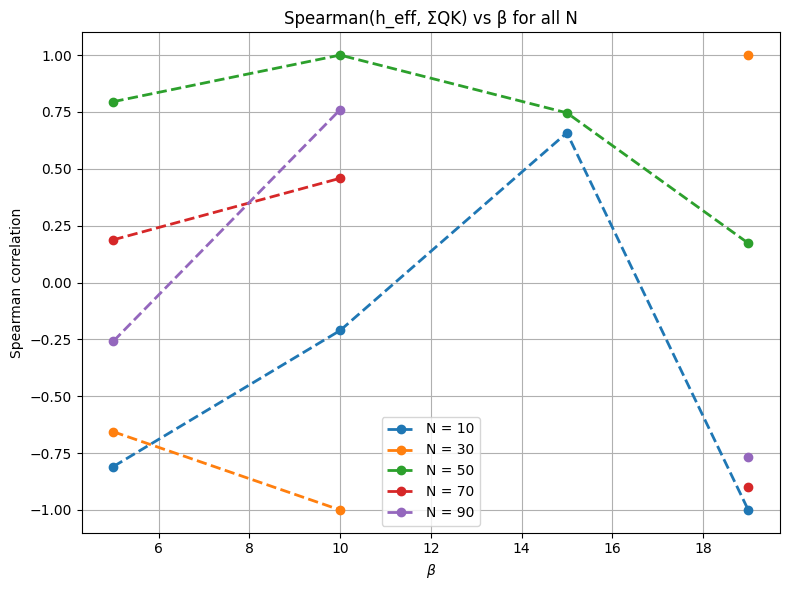

In [ ]:
# ============================================================
# METROPOLIS SAMPLER (SK MODEL)
# ============================================================

def metropolis_step(sigma, J, beta):
    """
    Perform a single Metropolis–Hastings spin-flip step for the
    Sherrington–Kirkpatrick (SK) spin glass model.

    Args:
        sigma (torch.Tensor): Shape (N,). Current spin configuration with
            entries in {+1, -1} on the same device as `J`.
        J (torch.Tensor): Shape (N, N). Symmetric coupling matrix with
            zero diagonal (J_ii = 0). Typically scaled as O(1/sqrt(N)).
        beta (float): Inverse temperature β = 1/T controlling acceptance
            of energetically unfavorable flips. Larger β ⇒ lower temperature.

    Returns:
        torch.Tensor: The (possibly) updated spin configuration `sigma`
        after proposing and accepting/rejecting a flip at a single site.

    Role in experiment:
        - This is the inner dynamics that generates samples from the
          SK equilibrium distribution at fixed β. The Transformer is trained
          on those samples to predict the spin at a held-out site from the rest.
    """
    # Randomly choose a site to propose a flip
    i = random.randrange(len(sigma))

    # Effective local field h_i = Σ_j J_{ij} σ_j
    h_eff_i = torch.dot(J[i], sigma)

    # Energy change for flipping σ_i → -σ_i is ΔE = 2 σ_i h_i
    delta_E = 2 * sigma[i] * h_eff_i

    # Metropolis acceptance: always accept if ΔE <= 0; otherwise accept with exp(-βΔE)
    if delta_E <= 0 or random.random() < math.exp(-beta * delta_E):
        sigma[i] *= -1

    return sigma


def sample_equilibrium(J, beta, steps=20000, burn_in=5000, thinning= 2):
    """
    Run the Metropolis sampler to draw (approximately) equilibrium spin
    configurations for the SK model at inverse temperature β.

    Args:
        J (torch.Tensor): Shape (N, N). Symmetric coupling matrix with J_ii = 0.
        beta (float): Inverse temperature.
        steps (int, optional): Total Metropolis steps to run. Default: 15000.
        burn_in (int, optional): Initial steps discarded to reach equilibrium.
            Default: 4000.
        thinning (int, optional): Keep one sample every `thinning` steps to
            reduce autocorrelation. Default: 20.

    Returns:
        torch.Tensor: Shape (M, N) where M ≈ (steps - burn_in) / thinning.
            A batch of thinned configurations drawn from the equilibrium
            distribution at the specified β.

    Role in experiment:
        - Produces the training/evaluation dataset: each sample is an SK spin
          configuration from which we ask the Transformer to predict the spin
          at a designated site from the remaining spins.
    """
    N = J.shape[0]

    # Random ±1 initialization on the same device as J (assumes `device` exists)
    sigma = (torch.randint(0, 2, (N,), device=device) * 2 - 1).float()

    samples = []
    for t in range(steps):
        sigma = metropolis_step(sigma, J, beta)

        # Collect thinned post–burn-in samples
        if t > burn_in and t % thinning == 0:
            samples.append(sigma.clone())

    return torch.stack(samples)


# ============================================================
# TRANSFORMER
# ============================================================

class SpinTransformer(nn.Module):
    """
    Minimal Transformer-like model that maps a vector of spins to per-site
    logits (binary classification) for predicting σ_i \in {−1, +1}.

    Architecture:
        - Linear embedding from 1-dim input (each spin) to d_model
        - Single Multihead Self-Attention layer (batch_first=True)
        - Feed-forward linear layer
        - Final linear classifier to 2 logits per site

    Intended usage in experiment:
        - Given an input spin configuration where one site (SITE) is masked
          (set to 0), the model tries to infer the held-out spin value by
          attending to the rest of the configuration. We then probe the model’s
          internal QK interactions to compare with the SK effective field.

    Args:
        d_model (int, optional): Embedding/attention hidden size. Default: 64.
    """
    def __init__(self, d_model=64):
        super().__init__()
        self.embed = nn.Linear(1, d_model)                     # per-spin embedding
        self.attn = nn.MultiheadAttention(d_model, 4, batch_first=True)  # self-attention
        self.ff = nn.Linear(d_model, d_model)                  # simple FF layer
        self.classifier = nn.Linear(d_model, 2)                # 2-class logits per site

    def forward(self, x):
        """
        Forward pass.

        Args:
            x (torch.Tensor): Shape (B, N). Batch of spin configurations
                (float tensor). The site to be predicted (SITE) is masked to 0.

        Returns:
            torch.Tensor: Shape (B, N, 2). For each site in the sequence,
                returns logits over the two classes {σ_i = -1, σ_i = +1}.

        Role in experiment:
            - During training, we read out logits[:, SITE] and apply cross-entropy
              against the true label for the masked site.
            - During analysis, we access attention internals (Q, K) to build a
              physics–ML correspondence between Σ_j J_{ij} σ_j and Σ_j Q_i·K_j.
        """
        # (B, N) → (B, N, 1) → (B, N, d_model)
        x = self.embed(x.unsqueeze(-1))

        # Self-attention (batch_first=True). We ignore the attention weights here.
        attn_out, _ = self.attn(x, x, x)

        # Residual-like path using the attention-induced delta (centered per sequence)
        delta = attn_out - x
        delta -= delta.mean(dim=1, keepdim=True)  # zero-mean across sites
        x = x + delta

        # Simple feed-forward projection and per-site classification
        x = self.ff(x)
        return self.classifier(x)


# ============================================================
# PARAMETERS
# ============================================================

N_values = [10, 30, 50, 70, 90]
beta_values = [5, 10, 15, 19]  # Phase transition behavior: empirical signs near β≈20 (not used directly here)

batch_size = 128
lr = 1e-3
SITE = 5         # Held-out index to predict. NOTE: must be < N for each setting.

results = {}


# ============================================================
# MAIN EXPERIMENT
# ============================================================
# For each system size N:
#   1) Draw an SK coupling matrix J ~ N(0, 1/N) symmetric, zero diag.
#   2) For each β, sample equilibrium spin configurations via Metropolis.
#   3) Build a dataset where the target is σ[SITE] and input masks that site to 0.
#   4) Train SpinTransformer to predict σ[SITE] from the rest.
#   5) Probe internal attention QK signals vs physical effective field h_i to
#      compute Spearman correlation across samples.

for N in N_values:
    epochs = int(5 * N)  # simple scaling of training epochs with system size

    print(f"\n===== N = {N} =====")
    results[N] = []

    # SK random couplings: symmetric, zero diagonal, variance 1/N
    J = torch.randn(N, N, device=device) / math.sqrt(N)
    J = (J + J.T) / 2
    J.fill_diagonal_(0)

    for beta in beta_values:
        print(f"  beta = {beta}")

        # --- Sampling from SK equilibrium at this β ---
        samples = sample_equilibrium(J, beta)

        # --- Dataset: mask SITE in input; label is σ[SITE] ---
        X, Y = [], []
        for s in samples:
            x = s.clone()
            y = s[SITE]               # true spin at held-out site
            x[SITE] = 0.0             # mask the site in the input
            X.append(x)
            Y.append(0 if y == -1 else 1)  # map {-1, +1} → {0, 1} for CE loss

        X = torch.stack(X).to(device)       # (M, N)
        Y = torch.tensor(Y, device=device)  # (M,)

        # --- Model / optimizer / loss ---
        model = SpinTransformer().to(device)
        opt = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        # --- Training loop (minibatched) ---
        for _ in range(epochs):
            perm = torch.randperm(len(X))
            for k in range(0, len(X), batch_size):
                idx = perm[k:k + batch_size]
                logits = model(X[idx])[:, SITE]  # read out logits for the held-out site
                loss = loss_fn(logits, Y[idx])
                opt.zero_grad()
                loss.backward()
                opt.step()

        # ====================================================
        # MEASUREMENTS: h_eff vs RAW QK
        # ====================================================
        # Compare physics effective field h_i = Σ_j J_{ij} σ_j at SITE
        # with the model's raw attention similarity Σ_j (Q_i · K_j) / sqrt(d)
        # (excluding self-site). We compute Spearman correlation across samples.

        h_vals = []
        qk_sum_vals = []
        pairwise_corrs = []  # optional diagnostic: corr per-site between J_{i·}σ and Q_i·K_·

        with torch.no_grad():
            for sigma in samples[:60]:  # analyze a subset for speed
                sigma = sigma.to(device)

                # --- Physics: effective field and pairwise term at SITE ---
                h_i = torch.dot(J[SITE], sigma)  # scalar effective field at SITE
                h_vals.append(h_i.item())
                phys_pairwise = J[SITE] * sigma  # vector of J_{i·} σ_·
                phys_pairwise[SITE] = 0.0        # ignore self

                # --- Transformer internals: extract raw Q and K ---
                x = model.embed(sigma.unsqueeze(0).unsqueeze(-1))  # (1, N, d)
                d = model.attn.embed_dim
                W = model.attn.in_proj_weight  # (3d, d) concatenated [Q; K; V]
                W_Q, W_K = W[:d], W[d:2*d]     # split out Q and K projection matrices

                Q = x @ W_Q.T                  # (1, N, d)
                K = x @ W_K.T                  # (1, N, d)

                q_i = Q[0, SITE]               # (d,)
                qk_raw = (K[0] @ q_i) / math.sqrt(d)  # (N,) raw dot-products normalized
                qk_raw[SITE] = 0.0

                qk_sum_vals.append(qk_raw.sum().item())

                # Per-site correlation between physics vector and attention vector (mask self)
                mask = torch.arange(N, device=device) != SITE
                corr = torch.corrcoef(torch.stack([phys_pairwise[mask], qk_raw[mask]]))[0, 1].item()
                pairwise_corrs.append(corr)

        # Rank correlation between scalar physics field and scalar Σ_j Q_i·K_j
        spearman, p_value = spearmanr(h_vals, qk_sum_vals)

        results[N].append((beta, spearman))

        print(f"Spearman = {spearman:.6f} | ")


# ============================================================
# PLOTS: Spearman correlation vs β (one figure per N)
# ============================================================
# Visualize how the (h_eff vs ΣQK) Spearman correlation varies with temperature (β)
# across system sizes N. This summarizes the physics–ML alignment.

plt.figure(figsize=(8, 6))

for N in results:
    data = np.array(results[N])

    # Sort by β for a clean line plot
    data = data[data[:, 0].argsort()]

    betas = data[:, 0]
    spearman_vals = data[:, 1]

    plt.plot(
        betas,
        spearman_vals,
        marker="o",
        linestyle="--",
        linewidth=2,
        markersize=6,
        label=f"N = {N}"
    )

    # Quick diagnostic: range and spread of h_i encountered (uses last loop's h_vals)
    print(
        "min(h) =", min(h_vals),
        "max(h) =", max(h_vals),
        "std(h) =", np.std(h_vals)
    )

plt.xlabel(r"$\beta$")
plt.ylabel("Spearman correlation")
plt.title("Spearman(h_eff, ΣQK) vs β for all N")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()